# Imports (make sure importing modules work properly)

In [1]:
# python 3.7
# pytorch -- stable 1.8.0 release 

import torch
import random
from scipy.ndimage.filters import gaussian_filter1d
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

# Download a pretrained VGG16 from Pytorch model zoo

In [2]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406])
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225])
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/ianscottknight/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Visualization Functions (Source CS231N @ Stanford University)

In [202]:
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# This will allow us to record input and output
class Hook(): 
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 500)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 100)

    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_() # initialize image
    
    # register hook at relevant Conv (index 28 of sequential module)
    module = list(vgg16.modules())[1][28]
    hook = Hook(module)
        
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        ########################################################################
        scores = model(img)
        #score = scores[:,target_y] - (l2_reg * torch.norm(img))
        #score.backward()
        score = hook.output - (l2_reg * torch.norm(img)) # keep image L2 norm but swap with registered hook output
        score.sum().backward()
        img.data += (learning_rate*img.grad.data/torch.norm(img.grad.data))
        img.grad.data.zero_()
        ########################################################################
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = str(target_y)
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

# Run Visualization (Takes ~10-15 minutes on cpu)

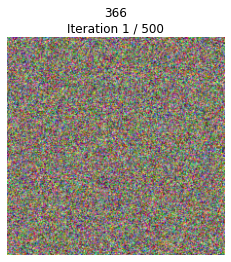

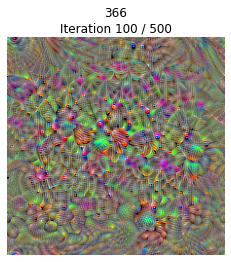

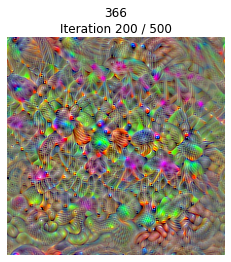

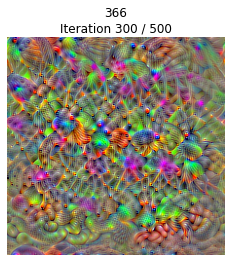

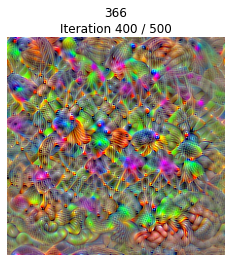

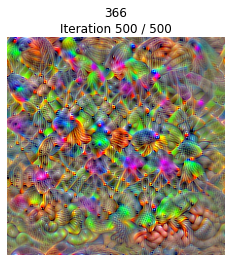

In [204]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
vgg16.type(dtype)

# target_y = 76  # Tarantula
# target_y = 78  # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y=target_y, model=vgg16, dtype=dtype)